In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML



import warnings

import numpy as np
import pandas as pd
import copy
import random

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

warnings.filterwarnings(action='once')

from filter_data import *
from load_and_clean import *

In [3]:
#global settings for graphs        
cc = (cycler(color=list('rgbcmyk')) *
      cycler(linestyle=['-', '--', '-.',':']))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)

In [4]:

update_data()

#Import, process and filter data

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')

global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')

mobility_data_apple, mobility_data_google = load_clean('mobility')

sd_data = load_clean('IHME intervention')

#global_country_aggr = global_covid.groupby('Country/Region').sum()

rolling_average_duration = 3
t = 5

daily_global = create_rolling_data(create_filtered_data(global_deaths,t), rolling_average_duration)
daily_us = create_rolling_data(create_filtered_data(usdeaths,t), rolling_average_duration)
daily_uscountines = create_rolling_data(create_filtered_data(uscounties_deaths,t), rolling_average_duration)



In [5]:
#us_school_closures
#educational_distancing[educational_distancing.country=="Italy"]
#educational_distancing.append({'country':'Spain', 'name':'Spain', 'date':'2020-03-14'}, ignore_index=True)

In [6]:
intervention_tried = sd_data.columns[7]
intervention_table = create_intervention_data(sd_data, intervention_tried) 
#intervention_table was the same as educational_distancing in previous version

/Users/codymorrin/Desktop/covid/COVID19-synthetic-contro-analysis/filter_data.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervention_table[intervention] = intervention_table[intervention].str.replace(".","-")
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Hamburg
   country     name Non-essential services closed date
6  Germany  Hamburg               not implemented  NaN
Hesse
   country   name Non-essential services closed date
7  Germany  Hesse               not implemented  NaN
Saarland
    country      name Non-essential services closed date
12  Germany  Saarland               not implemented  NaN
Thuringia
    country       name Non-essential services closed date
16  Germany  Thuringia               not implemented  NaN
Arizona
   country     name Non-essential services closed date
40     USA  Arizona               not implemented  NaN
Arkansas
   country      name Non-essential services closed date
41     USA  Arkansas               not implemented  NaN
Florida
   country     name Non-essential services closed date
48     USA  Florida               not implemented  NaN
Georgia
   country     name Non-essential services closed date
49     USA  Georgia               not implemented  NaN
Iowa
   country  name Non-essential services c

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/codymorrin/Desktop/covid/COVID19-synthetic-contro-analysis/filter_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervention_table.loc[intervention_table.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [7]:
lag = 7
newdf_global = filter_data_by_intervention(global_deaths, intervention_table, lag)
newdf_us = filter_data_by_intervention(usdeaths, intervention_table, lag)

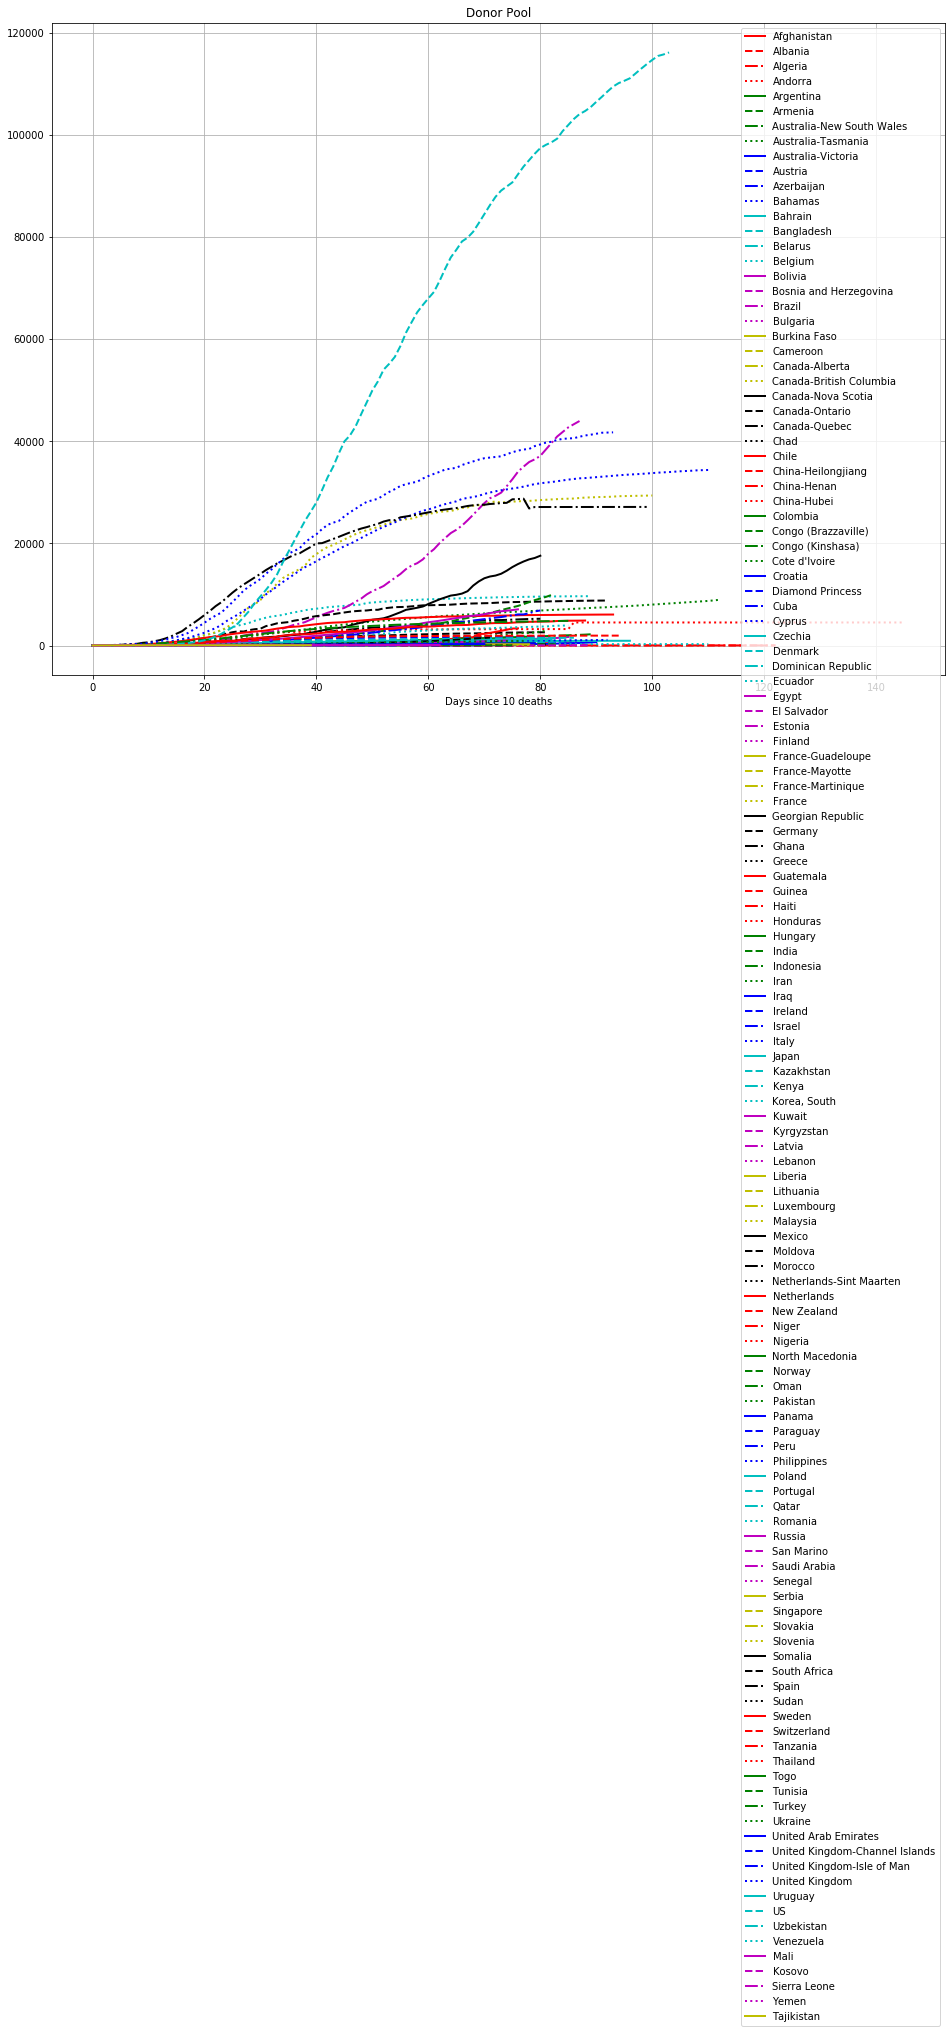

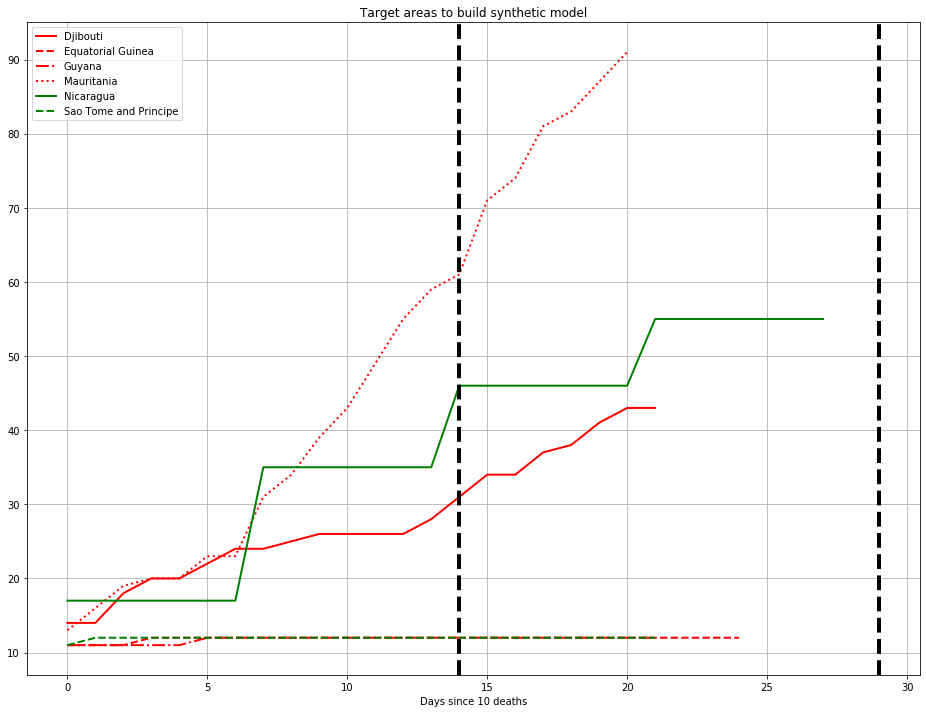

In [8]:
global_deaths_filtered = create_filtered_data(global_deaths, 10 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=15
threshold=30
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot(figsize=(16,12), grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(figsize=(16,12), grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [9]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [10]:
matching = [s for s in newdf_global.columns if "7" in s]
matching_us = [s for s in newdf.columns if "7" in s]

NameError: name 'newdf' is not defined

In [ ]:
rolling_average_duration = 5
daily_global = create_rolling_data(newdf_global, rolling_average_duration)
daily_us = create_rolling_data(daily_us, rolling_average_duration)

#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [ ]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

In [ ]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
#trial = pd.concat([create_filtered_data(global_deaths, 10), create_filtered_data(usdeaths, 5)], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #sizes = sizes.fillna(0).astype(int)
    print(sizes)
    length = sizes.loc[target]
    print(length)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    #synth_control_predictions2(trial,40,25, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" plus 7"], showstates=10,
    #                           exclude=matching+matching_us)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
    #topstates = synth_control_predictions2(trial,35,length-(rolling_average_duration+2), "Deaths Data", 2, ylimit=[], savePlots=False, exclude=['US'],
                              #          do_only=[target], showstates=8)
    #synth_control_predictions2(trial,35,15, "Deaths Data", 2, ylimit=[], savePlots=False, donorPool=topstates,
                            #do_only=[target], showstates=3)

In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
target =  ['New York City-New York']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#target = ['Riverside-California']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
trial = pd.concat([daily_global, daily_uscountines], axis=1)

fig = plt.figure(figsize=(16,6))

camera = Camera(fig)


    


for i in range(20):
    
    #print("Global threshold is ",5, "Counties threshold is ", 2)
    synth_control_predictions2(trial,35,5+i, "Rolling 5-day average deaths data", 2, ylimit=[], savePlots=False, do_only=target, showstates=12,
                               exclude=exclude1, animation=camera)
    #camera.snap()
    #plt.figure(figsize=(16,6))
    #synth_control_predictions2(trial,0,15+i, "Deaths Data", 2, ylimit=[], savePlots=False, 
    #                           exclude=exclude1 + exclude2, do_only=target, showstates=3)
#plt.legend()    
animation = camera.animate()
HTML(animation.to_html5_video())

#animation.save('../New York Western Europe.mp4')

In [ ]:
newdf_global = pd.DataFrame()
for i in range(0, 20):
    #usdeaths[usdeaths.index>intervention_date[0]]
    for state in global_deaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            newdata = global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" plus %s"%i], 
            #                                      data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            
            if i == 0:
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state], 
                                                       data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


In [ ]:
newdf = pd.DataFrame()
for i in range(0,20):
    for state in usdeaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            #newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" plus 7"], 
            #                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=7)][state].values)], axis=1)
            if i == 0:
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state], 
                                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            #newdf = pd.concat([newdf, pd.DataFrame(columns=[state+"minus 7"], data=usdeaths.loc[usdeaths.index>=intervention_date[0]-7][state].values)], axis=1)


In [ ]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [ ]:
matching = []
matching_us = []
for i in range(1,20):
    matching = matching + [s for s in newdf_global.columns if str(i) in s]
    matching_us = matching_us + [s for s in newdf.columns if str(i) in s]

print(matching)


In [ ]:
rolling_average_duration = 5

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

In [ ]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

In [ ]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
#trial = pd.concat([create_filtered_data(global_deaths, 10), create_filtered_data(usdeaths, 5)], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #print(sizes)
    length = sizes.loc[target]
    #print(length)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
   


In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
target =  ['New York']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#target = ['Riverside-California']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
fig = plt.figure(figsize=(16,6))

camera = Camera(fig)
singVals =3

    


for i in range(1,20):
    
    #print("Global threshold is ",5, "Counties threshold is ", 2)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target[0]+" minus %s"%i], showstates=12,
                               exclude=matching+matching_us, animation=camera)
    #synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
    #                          exclude=matching+matching_us+[target])
    #camera.snap()
    #plt.figure(figsize=(16,6))
    #synth_control_predictions2(trial,0,15+i, "Deaths Data", 2, ylimit=[], savePlots=False, 
    #                           exclude=exclude1 + exclude2, do_only=target, showstates=3)
#plt.legend()    
animation = camera.animate()
HTML(animation.to_html5_video())

#animation.save('../New York Western Europe.mp4')

In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
targets =  ['New York']#'Italy', 'France', 'United Kingdom', 'New York', 'Spain', 'Switzerland']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#targets = ['Switzerland', 'Belgium']# 'Netherlands']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)

#fig = plt.figure(figsize=(16,6))
#camera = Camera(fig)
singVals =2  

   

for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,20):
        synth_control_predictions2(trial,38,21, "Rolling 5-day average deaths data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus %s"%i], showstates=12,
                                   exclude=matching+matching_us, animation=camera)
animation = camera.animate()

HTML(animation.to_html5_video())

    #animation.save('../animations/'+target+" no donors shown"'.mp4')
